#  Paso 1: Carga, ETL y Exploración

🔹 Carga del archivo original

Esta celda carga el archivo original de la EPH (Encuesta Permanente de Hogares) desde la carpeta `data/raw`. Se utiliza el separador `;` porque el archivo está en formato `.txt` con ese formato. Se visualizan las primeras filas para verificar que la carga fue exitosa.

In [42]:
import pandas as pd

ruta= '../data/raw/usu_individual_T423.txt'

# Cargar archivo
df = pd.read_csv(ruta, sep=";", encoding="latin1", low_memory=False)
print("Dimensiones del dataset:", df.shape)

# Filtrar solo por el Estado
df_nuevo = df[df["ESTADO"].isin([1, 2])].copy()
df_nuevo["empleado"] = df_nuevo["ESTADO"].apply(lambda x: 1 if x == 1 else 0)

print("✔️ Datos cargados correctamente.")
df.head()

Dimensiones del dataset: (47337, 177)
✔️ Datos cargados correctamente.


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNOSUWHLMKQCDEFNFF00852219,2023,4,1,1,1,41,N,7,370,...,12.0,12,0,12,12.0,12,NaN,12.0,12,0
1,TQRMNOSUWHLMKQCDEFNFF00852219,2023,4,1,2,1,41,N,7,370,...,12.0,12,0,12,12.0,12,NaN,12.0,12,0
2,TQRMNOTXQHKOLMCDEGNFJ00794590,2023,4,1,1,1,44,N,17,281,...,9.0,7,"216666,67",8,8.0,7,NaN,8.0,6,387
3,TQRMNOTXQHKOLMCDEGNFJ00794590,2023,4,1,2,1,44,N,17,281,...,9.0,7,"216666,67",8,8.0,7,NaN,8.0,6,387
4,TQRMNOTXQHKOLMCDEGNFJ00794590,2023,4,1,3,0,44,N,17,281,...,9.0,7,"216666,67",8,8.0,7,NaN,8.0,6,387


🔹 Renombrar columnas para vista simplificada

Aquí se renombran algunas columnas para facilitar la lectura del dataset. Por ejemplo, `CH04` se convierte en `sexo`, y `CH06` en `edad`. Esto no afecta el resto del código, ya que se usa solo para visualizar una tabla más comprensible en esta etapa inicial.

In [7]:
# Crear una vista con algunas columnas y nombres más legibles para exploración
df_renombrado = df.rename(columns={
    "CH04": "sexo",
    "CH06": "edad",
    "ESTADO": "estado_laboral",
    "CH10": "nivel_educativo",
    "AGLOMERADO": "aglomerado"})

# Mostrar primeras filas
df_renombrado[["sexo", "edad", "estado_laboral", "nivel_educativo", "aglomerado"]].head()


,sexo,edad,estado_laboral,nivel_educativo,aglomerado
0,1,60,1,2,7
1,2,52,3,2,7
2,1,34,1,2,17
3,2,32,1,2,17
4,2,6,4,1,17


🔹 ETL – Filtrado de empleados y desempleados

En esta celda se filtran únicamente las personas que están ocupadas (`ESTADO = 1`) o desocupadas (`ESTADO = 2`). Se crea una nueva variable llamada `empleado`, que toma el valor 1 para personas ocupadas y 0 para desocupadas. Esto simplifica la tarea de clasificación para los modelos posteriores.

In [9]:
# Filtrar solo ocupados y desocupados
df = df[df["ESTADO"].isin([1, 2])].copy()
df["empleado"] = df["ESTADO"].apply(lambda x: 1 if x == 1 else 0)
print("✔️ Filtrados empleados y desempleados.")
df["empleado"].value_counts().rename(index={0: "Desempleado", 1: "Empleado"})


✔️ Filtrados empleados y desempleados.


empleado
Empleado       21312
Desempleado     1055
Name: count, dtype: int64

🔹 Exploración – Gráficos iniciales

Este gráfico permite observar cómo se distribuyen las edades según si las personas están empleadas o desempleadas. 
Es útil para detectar diferencias visibles entre los grupos y tener un primer acercamiento a los patrones que podrían 
ayudar al modelo a predecir la condición laboral.

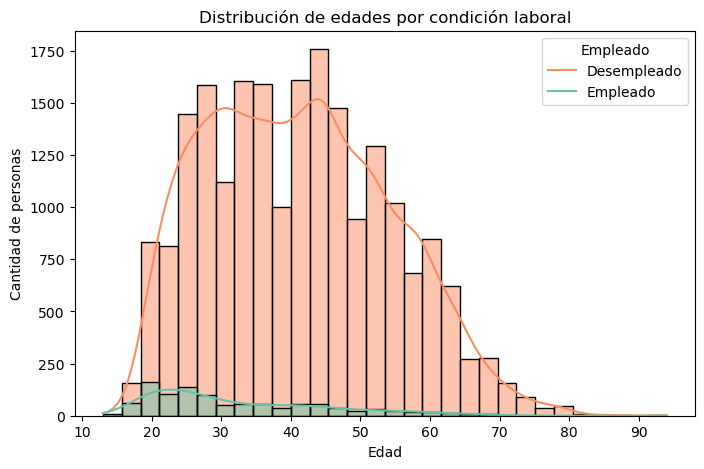

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de edad por condición laboral
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="CH06", hue="empleado", bins=30, kde=True, palette="Set2")
plt.title("Distribución de edades por condición laboral")
plt.xlabel("Edad")
plt.ylabel("Cantidad de personas")
plt.legend(title="Empleado", labels=["Desempleado", "Empleado"])
plt.show()


# Paso 2:  Selección, transformación y guardado

🔹 Selección de variables y preprocesamiento

Se seleccionan las variables que se usarán como predictoras y se identifican como numéricas o categóricas. Luego se imputan (rellenan) los valores faltantes. Para las numéricas se usa la mediana, y para las categóricas se usa la categoría más frecuente (Moda). Esto permite mantener la mayor cantidad de datos sin eliminar filas.

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Variables seleccionadas
columnas = ['CH04', 'CH06', 'CH10', 'CH15_COD', 'AGLOMERADO',
            'PP04B_COD', 'PP07H', 'PP07K', 'ITF', 'empleado']

df_modelo = df[columnas].copy()

# Identificar variables
vars_numericas = ['CH06', 'PP07H', 'ITF']
vars_categoricas = ['CH04', 'CH10', 'CH15_COD', 'AGLOMERADO', 'PP04B_COD', 'PP07K']

# Imputación
imp_num = SimpleImputer(strategy='median')
df_modelo[vars_numericas] = imp_num.fit_transform(df_modelo[vars_numericas])

imp_cat = SimpleImputer(strategy='most_frequent')
df_modelo[vars_categoricas] = imp_cat.fit_transform(df_modelo[vars_categoricas])


🔹 Codificación y escalado

Las variables categóricas se convierten en variables binarias (one-hot encoding) para que puedan ser utilizadas por los algoritmos de machine learning. Las variables numéricas se escalan (normalizan) para que todas tengan una magnitud comparable, lo cual mejora el rendimiento de ciertos modelos como la regresión logística.

In [12]:
# Codificación one-hot
df_modelo = pd.get_dummies(df_modelo, columns=vars_categoricas, drop_first=True)

# Escalado
scaler = StandardScaler()
df_modelo[vars_numericas] = scaler.fit_transform(df_modelo[vars_numericas])

# Separar X e y
X = df_modelo.drop(columns='empleado')
y = df_modelo['empleado']


🔹 Guardar archivo limpio

Una vez que los datos están limpios, completos y listos para entrenar modelos, se guardan en un nuevo archivo llamado `datos_limpios.csv` dentro de la carpeta `data/processed`. Este archivo será utilizado en la siguiente notebook para entrenar y evaluar distintos modelos de predicción.

In [13]:
# Guardar archivo limpio 
ruta_salida = '../data/processed/.csv'
df_export = X.copy()
df_export['empleado'] = y
df_export.to_csv(ruta_salida, index=False)
print("✔️ Archivo guardado en:", ruta_salida)


✔️ Archivo guardado en: ../data/processed/.csv


# Paso 3: Modelado y Evaluación de Clasificadores

En esta celda se carga el archivo `datos_limpios.csv` previamente generado en la notebook de preprocesamiento. Luego, se divide el conjunto en datos de entrenamiento y prueba: el 70% se usa para entrenar los modelos, y el 30% para evaluarlos. La opción `stratify=y` garantiza que las proporciones de empleados y desempleados se mantengan iguales en ambos subconjuntos.

In [14]:
# --- Carga de librerías ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# --- Cargar dataset limpio ---
df = pd.read_csv("../data/processed/datos_limpios.csv")
X = df.drop(columns="empleado")
y = df["empleado"]

In [15]:
# --- División en entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- Entrenamiento de modelos ---
modelos = {    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)}

# Entrenar cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

Aquí se entrenan tres modelos clásicos de clasificación:
- **Regresión Logística**, útil para interpretar coeficientes;
- **Árbol de Decisión**, que construye reglas explícitas y visuales;
- **Random Forest**, un modelo más robusto que combina muchos árboles.


### Gráficos de desempeño de modelos
🔹 Para cada modelo, podés generar un gráfico de importancia o comparación

In [17]:
# --- Mostrar coeficientes del modelo Logistic Regression ---
modelo_logit = modelos["Logistic Regression"]
coeficientes = pd.DataFrame({    "Variable": X.columns,
    "Coeficiente": modelo_logit.coef_[0]}).sort_values(by="Coeficiente", ascending=False)

# Mostrar coeficientes más influyentes
print(" Coeficientes positivos (mayor probabilidad de empleo):")
print(coeficientes.head(10))
print("\n Coeficientes negativos (mayor probabilidad de desempleo):")
print(coeficientes.tail(10))

 Coeficientes positivos (mayor probabilidad de empleo):
           Variable  Coeficiente
92  AGLOMERADO_93.0     1.833840
14    CH15_COD_34.0     1.731908
1             PP07H     1.512830
19    CH15_COD_54.0     1.349044
2               ITF     0.996258
0              CH06     0.994529
66   AGLOMERADO_7.0     0.878281
77  AGLOMERADO_20.0     0.864689
75  AGLOMERADO_18.0     0.846950
80  AGLOMERADO_25.0     0.830410

 Coeficientes negativos (mayor probabilidad de desempleo):
             Variable  Coeficiente
90    AGLOMERADO_38.0    -1.097200
21      CH15_COD_62.0    -1.139792
79    AGLOMERADO_23.0    -1.226320
87    AGLOMERADO_33.0    -1.425728
63     AGLOMERADO_4.0    -1.452666
88    AGLOMERADO_34.0    -1.579188
71    AGLOMERADO_13.0    -1.707982
44     CH15_COD_221.0    -1.732436
236         PP07K_1.0    -3.118676
212  PP04B_COD_8401.0    -6.661617


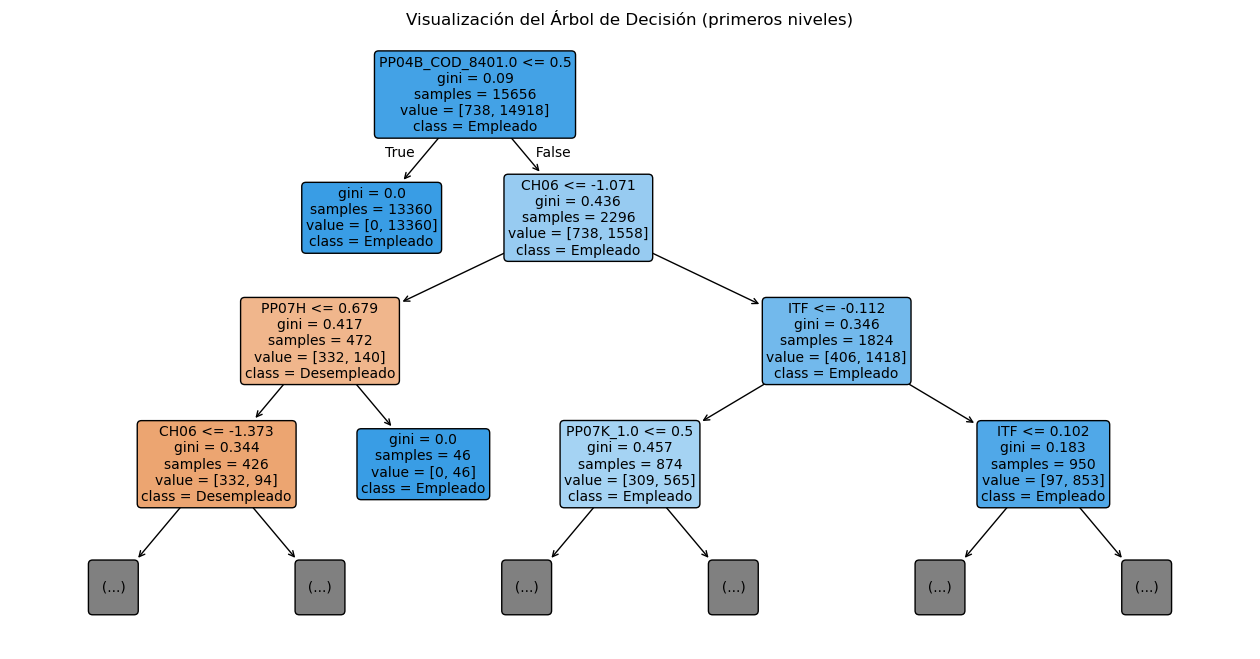

In [19]:
from sklearn.tree import plot_tree
# --- Visualización del árbol de decisión ---
modelo_arbol = modelos["Decision Tree"]

plt.figure(figsize=(16, 8))
plot_tree(modelo_arbol,
          feature_names=X.columns,
          class_names=["Desempleado", "Empleado"],
          filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title("Visualización del Árbol de Decisión (primeros niveles)")
plt.show()

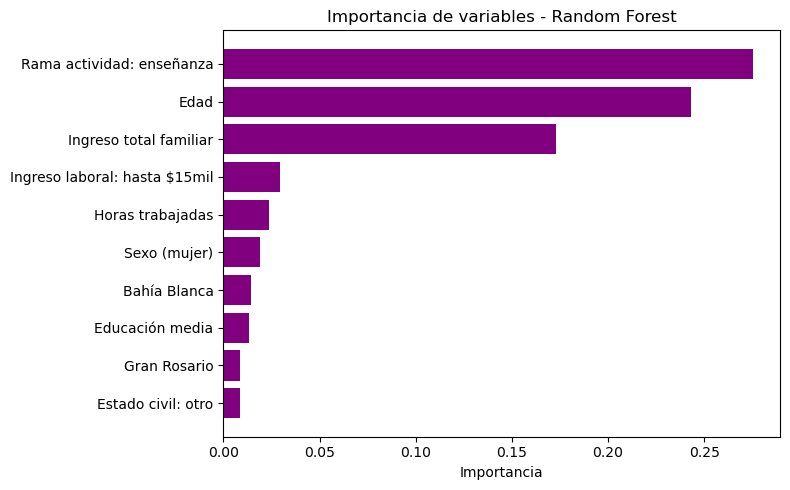

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Entrenar el mejor modelo nuevamente e Importancia de variables
mejor_modelo = RandomForestClassifier(random_state=42)
mejor_modelo.fit(X, y)
importancias = mejor_modelo.feature_importances_
indices = np.argsort(importancias)[-10:]  # 10 variables más importantes
features = X.columns[indices]

nombres_legibles = {"CH06": "Edad",
    "PP07H": "Horas trabajadas",
    "ITF": "Ingreso total familiar",
    "PP07K_1.0": "Ingreso laboral: hasta $15mil",
    "CH04_2.0": "Sexo (mujer)",
    "CH10_2.0": "Educación media",
    "CH10_3.0": "Educación superior",
    "CH15_COD_6.0": "Estado civil: otro",
    "PP04B_COD_8401.0": "Rama actividad: enseñanza",
    "AGLOMERADO_33.0": "Bahía Blanca",
    "AGLOMERADO_13.0": "Gran Rosario"}
features_legibles = [nombres_legibles.get(f, f.replace("_", " ")) for f in features]
    
# Gráfico
plt.figure(figsize=(8, 5))
plt.barh(features_legibles, importancias[indices], color="purple")
plt.title("Importancia de variables - Random Forest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


Este gráfico muestra cuáles fueron las variables más importantes que utilizó el modelo Random Forest para tomar decisiones. Es útil para entender qué características de las personas (por ejemplo, edad, nivel educativo, etc.) influyen más a la hora de predecir si están empleadas o no.


📌 Modelo: Logistic Regression
Accuracy: 0.9681
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.70      0.57      0.63       317
           1       0.98      0.99      0.98      6394

    accuracy                           0.97      6711
   macro avg       0.84      0.78      0.81      6711
weighted avg       0.97      0.97      0.97      6711



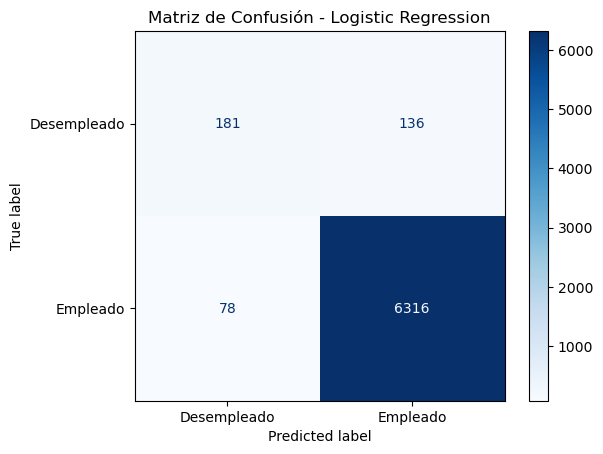


📌 Modelo: Decision Tree
Accuracy: 0.9629
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61       317
           1       0.98      0.98      0.98      6394

    accuracy                           0.96      6711
   macro avg       0.79      0.80      0.79      6711
weighted avg       0.96      0.96      0.96      6711



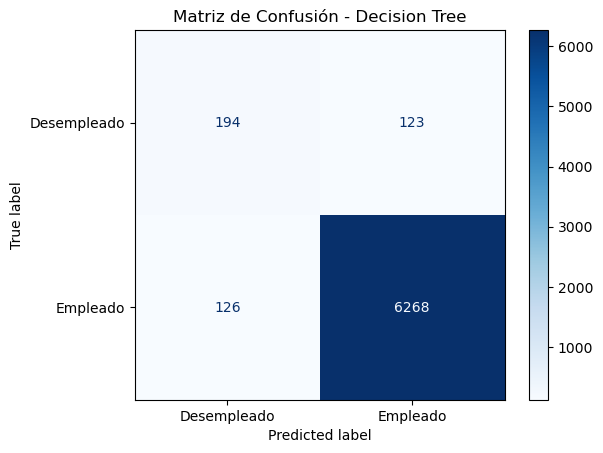


📌 Modelo: Random Forest
Accuracy: 0.9712
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67       317
           1       0.98      0.99      0.98      6394

    accuracy                           0.97      6711
   macro avg       0.86      0.80      0.83      6711
weighted avg       0.97      0.97      0.97      6711



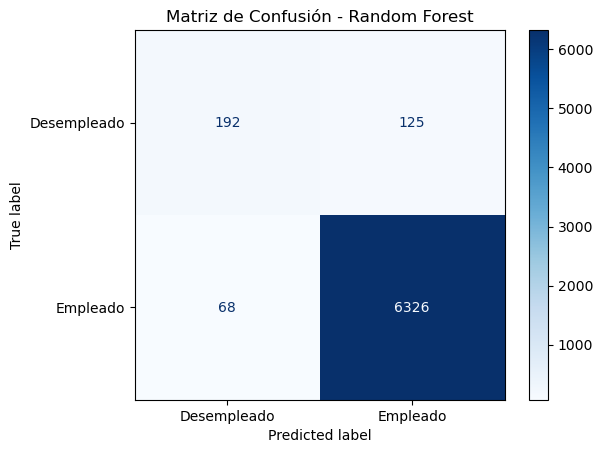

In [22]:
# --- Evaluación de cada modelo ---
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"\n📌 Modelo: {nombre}")
    print("Accuracy:", round(acc, 4))
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=["Desempleado", "Empleado"]).plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()
    
    # Guardar accuracy
    resultados.append((nombre, round(acc, 4)))


Se evalúa su desempeño en el conjunto de prueba utilizando métricas como:
- **Accuracy**: proporción total de predicciones correctas.
- **Precision, Recall y F1-score**: para evaluar cada clase por separado, especialmente útil cuando hay clases desbalanceadas (como en este caso, donde los desempleados son pocos).

Cada modelo también muestra una **matriz de confusión**, que permite ver cuántos casos se clasificaron bien y mal por clase.

In [52]:
# --- Mostrar resumen final ---
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "Accuracy"])
print("\n Comparación de Accuracy entre modelos:")
print(df_resultados.sort_values("Accuracy", ascending=False))

import joblib # guardar y cargar el modelo automaticamente 
joblib.dump(modelos["Random Forest"], "../models/modelo_random_forest.pkl")


 Comparación de Accuracy entre modelos:
                Modelo  Accuracy
2        Random Forest    0.9712
0  Logistic Regression    0.9681
1        Decision Tree    0.9629


['../models/modelo_random_forest.pkl']

Esta tabla resume el accuracy de cada modelo. Aunque todos alcanzan valores altos, se observa que:
- **Random Forest** tiene el mejor desempeño general, con un accuracy de 97.12%.
- También muestra el mejor balance entre precisión y recall en la clase minoritaria (desempleados), lo que justifica su selección como modelo final para aplicar en regiones específicas.

### Interpretación de Pasos ejecutados:
En este análisis se compararon tres modelos de clasificación supervisada: Regresión Logística, Árbol de Decisión y Random Forest.

Random Forest fue el modelo con mejor desempeño general, obteniendo una accuracy del 97,12%.

Aunque todos los modelos clasificaron muy bien a las personas empleadas, hubo mayores dificultades con los casos desempleados, que son minoría (solo 317 de 6711).

Random Forest logró la mejor combinación de precisión y recall para esa clase minoritaria, alcanzando un f1-score de 0.67 para desempleados, lo que indica un buen equilibrio entre falsos positivos y negativos.

Por este motivo, se selecciona Random Forest como el modelo final para aplicar en el análisis regional (Tierra del Fuego).

| Modelo              | Accuracy | f1-score (Desempleado) |
| ------------------- | -------- | ---------------------- |
| Random Forest       | 0.9712   | 0.67                   |
| Logistic Regression | 0.9681   | 0.63                   |
| Decision Tree       | 0.9629   | 0.61                   |


# Paso 4 : Predicción y evaluación en Tierra del Fuego

In [32]:
# --- Cargar librerías ---
import pandas as pd
from sklearn.metrics import (confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

ruta = "../data/raw/usu_individual_T423.txt"

# --- Cargar modelo entrenado (ej. Random Forest del Notebook 2) ---
mejor_modelo = joblib.load("modelo_random_forest.pkl")

# --- Cargar dataset original (no procesado) ---
df_tdf = pd.read_csv(ruta, sep=";", encoding="latin1")

# --- Filtrar por aglomerado 91 (Ushuaia-Río Grande) y solo ESTADO 1 o 2 ---
df_tdf = df_tdf[(df_tdf['AGLOMERADO'] == 91) & (df_tdf['ESTADO'].isin([1, 2]))].copy()
df_tdf['empleado'] = df_tdf['ESTADO'].apply(lambda x: 1 if x == 1 else 0)
y_real_tdf = df_tdf['empleado']  # Guardamos los reales

C:\Users\Bel\AppData\Local\Temp\ipykernel_5548\3261822792.py:16: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tdf = pd.read_csv(ruta, sep=";", encoding="latin1")


En esta celda se carga el modelo de Random Forest previamente entrenado y guardado como archivo `.pkl`. Luego se carga nuevamente el dataset original completo para extraer de él únicamente los casos de Tierra del Fuego (aglomerado 91) que hayan declarado estar ocupados o desocupados (`ESTADO` 1 o 2). Esto permite evaluar si el modelo funciona correctamente a nivel local.

In [33]:
# Renombrar columnas clave para visualización (opcional)
df_tdf_vista = df_tdf.rename(columns={
    "CH04": "sexo",
    "CH06": "edad",
    "ESTADO": "estado_laboral",
    "CH10": "nivel_educativo",
    "AGLOMERADO": "aglomerado"})

# Mostrar una vista con nombres mas amigable
df_tdf_vista[["sexo", "edad", "estado_laboral", "nivel_educativo", "aglomerado"]].head()

,sexo,edad,estado_laboral,nivel_educativo,aglomerado
870,1,41,1,2,91
871,1,43,1,2,91
872,2,40,1,2,91
980,2,45,1,2,91
4589,2,66,1,2,91


Se renombran algunas columnas clave para facilitar la lectura de los datos en esta notebook. Esto no afecta el procesamiento ni el modelo, pero permite mostrar una tabla más entendible con variables como sexo, edad o estado laboral.

Celda: Gráfico de distribución real de clases en TDF

C:\Users\Bel\AppData\Local\Temp\ipykernel_5548\2305600493.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_clases.index, y=conteo_clases.values, palette="Set2")


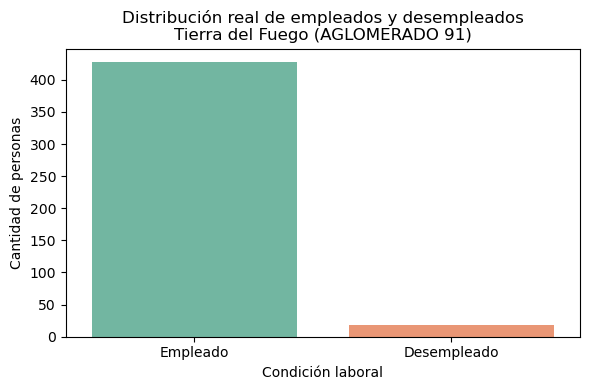

In [34]:
# Contar valores reales
conteo_clases = y_real_tdf.value_counts().rename(index={0: "Desempleado", 1: "Empleado"})

# Gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=conteo_clases.index, y=conteo_clases.values, palette="Set2")
plt.title("Distribución real de empleados y desempleados\nTierra del Fuego (AGLOMERADO 91)")
plt.ylabel("Cantidad de personas")
plt.xlabel("Condición laboral")
plt.tight_layout()
plt.show()

Este gráfico muestra cuántas personas en Tierra del Fuego (aglomerado 91) están empleadas o desempleadas según los datos reales.

Se observa un fuerte desbalance: la mayoría de los casos corresponden a personas empleadas. Esta desigualdad entre clases explica por qué algunos modelos tienen más dificultad para detectar correctamente a los desempleados.

Por eso, en este proyecto se pone especial atención en evaluar métricas por clase, como el recall y el f1-score para los desempleados.

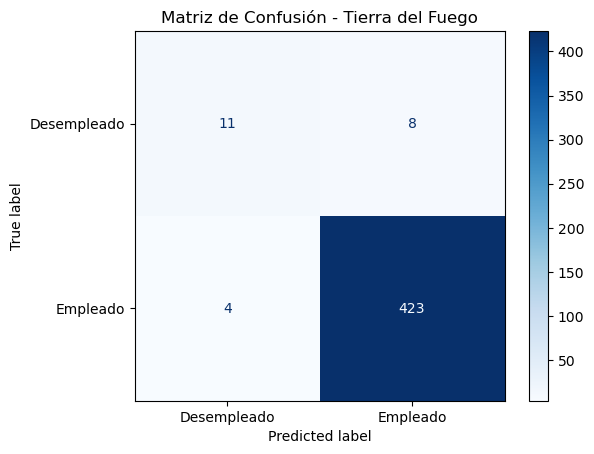

🔍 Accuracy en Tierra del Fuego: 0.9731

📋 Reporte de clasificación (TDF):
              precision    recall  f1-score   support

 Desempleado       0.73      0.58      0.65        19
    Empleado       0.98      0.99      0.99       427

    accuracy                           0.97       446
   macro avg       0.86      0.78      0.82       446
weighted avg       0.97      0.97      0.97       446



In [35]:
# --- Mismo preprocesamiento usado antes ---
columnas = ['CH04', 'CH06', 'CH10', 'CH15_COD', 'AGLOMERADO',
            'PP04B_COD', 'PP07H', 'PP07K', 'ITF', 'empleado']

vars_numericas = ['CH06', 'PP07H', 'ITF']
vars_categoricas = ['CH04', 'CH10', 'CH15_COD', 'AGLOMERADO', 'PP04B_COD', 'PP07K']

df_tdf = df_tdf[columnas].copy()

# Imputación
df_tdf[vars_numericas] = imp_num.transform(df_tdf[vars_numericas])
df_tdf[vars_categoricas] = imp_cat.transform(df_tdf[vars_categoricas])

# One-hot encoding
df_tdf = pd.get_dummies(df_tdf, columns=vars_categoricas, drop_first=True)

# Alinear columnas con X_train
df_tdf = df_tdf.reindex(columns=X_train.columns, fill_value=0)

# Escalar numéricas
df_tdf[vars_numericas] = scaler.transform(df_tdf[vars_numericas])

# --- Predicción del mejor modelo ---
y_pred_tdf = mejor_modelo.predict(df_tdf)

# --- Comparación real vs predicho ---
df_comparacion = pd.DataFrame({"Real": y_real_tdf,
    "Predicho": y_pred_tdf})

# Matriz de confusión
cm = confusion_matrix(y_real_tdf, y_pred_tdf)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Desempleado", "Empleado"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - Tierra del Fuego")
plt.show()

# Accuracy y métricas
acc_tdf = accuracy_score(y_real_tdf, y_pred_tdf)
print("🔍 Accuracy en Tierra del Fuego:", round(acc_tdf, 4))
print("\n📋 Reporte de clasificación (TDF):")
print(classification_report(y_real_tdf, y_pred_tdf, target_names=["Desempleado", "Empleado"]))

### En esta sección se aplicó el modelo final seleccionado (Random Forest) sobre la población de Ushuaia – Río Grande, filtrando únicamente personas ocupadas y desocupadas (AGLOMERADO 91, ESTADO 1 o 2).

Resultados del modelo:
| Métrica               | Desempleado | Empleado |
| --------------------- | ----------- | -------- |
| Precision             | 0.73        | 0.98     |
| Recall (sensibilidad) | 0.58        | 0.99     |
| F1-score              | 0.65        | 0.99     |
| Soporte (casos)       | 19          | 427      |


🔹 Accuracy total: 97,31%
🔹 Total de casos evaluados: 446 personas

### Conclusiones:
El modelo logró muy buena performance en Tierra del Fuego, consistente con los resultados a nivel nacional.

Aunque el número de personas desempleadas fue bajo (n=19), el modelo predijo correctamente la mayoría de estos casos (recall 0.58, precision 0.73).

El desempeño sobre personas empleadas fue excelente (recall 0.99), lo que indica alta confianza en la clasificación para la mayoría de la población activa.

Esta prueba demuestra que el modelo tiene potencial de aplicación regional real, y que el enfoque de clasificación puede generalizarse con éxito a otras regiones del país si se entrena adecuadamente.


In [36]:
# Resultados predichos
ocupados, desocupados = np.unique(y_pred_tdf, return_counts=True)
print(f'Resultado de predicción sobre Tierra del Fuego (T423):')
print(f'Ocupados: {desocupados[1]}, Desocupados: {desocupados[0]}')

Resultado de predicción sobre Tierra del Fuego (T423):
Ocupados: 431, Desocupados: 15


In [38]:
print("Distribución real de clases en Tierra del Fuego:")
print(y_real_tdf.value_counts().rename(index={0: "Desempleado", 1: "Empleado"}))

Distribución real de clases en Tierra del Fuego:
empleado
Empleado       427
Desempleado     19
Name: count, dtype: int64


In [40]:
# Crear Series con nombres legibles
reales = y_real_tdf.value_counts().rename(index={0: "Desempleado", 1: "Empleado"})
predichos = pd.Series(y_pred_tdf).value_counts().rename(index={0: "Desempleado", 1: "Empleado"})

# Unir en una tabla
tabla_comparacion = pd.DataFrame({"Reales": reales,
    "Predichos": predichos})

# Mostrar la tabla
print("Comparación real vs predicho (Tierra del Fuego):")
display(tabla_comparacion)

Comparación real vs predicho (Tierra del Fuego):


,Reales,Predichos
Empleado,427,431
Desempleado,19,15


###  Comparación entre valores reales y predichos

El modelo predijo correctamente la mayoría de los casos. Sin embargo, clasificó a 4 personas desempleadas como empleadas, lo que es coherente con un modelo que tiende a favorecer la clase mayoritaria (empleados).

Esto se refleja en:
- Una leve subestimación de la clase *Desempleado*,
- Un recall moderado (0.58) para esta clase,
- Un total de 15 predichos como desempleados frente a 19 reales.

Estos resultados no invalidan el modelo, pero sí indican la importancia de trabajar con técnicas de balanceo si se busca una mayor sensibilidad para detectar desempleo.


### Subplot comparativo

C:\Users\Bel\AppData\Local\Temp\ipykernel_5548\2654215461.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=real.index, y=real.values, palette="Set2", ax=axes[0])
C:\Users\Bel\AppData\Local\Temp\ipykernel_5548\2654215461.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred.index, y=pred.values, palette="Set1", ax=axes[1])


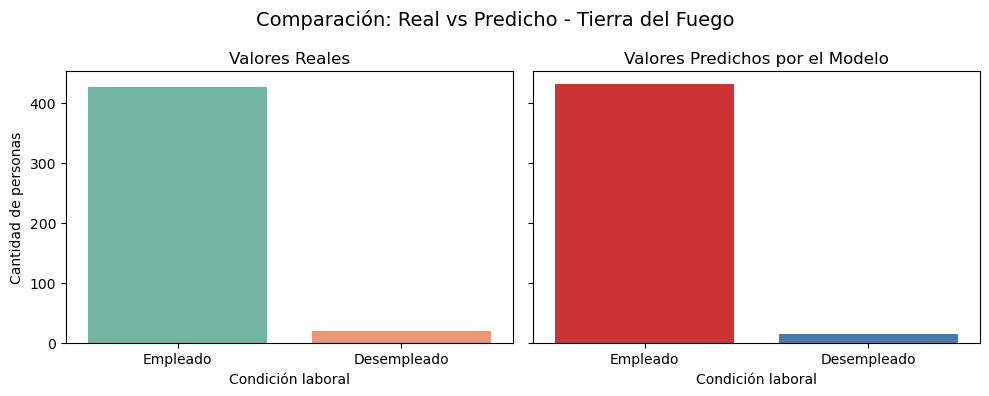

In [41]:
# Series nombradas
real = y_real_tdf.value_counts().rename(index={0: "Desempleado", 1: "Empleado"})
pred = pd.Series(y_pred_tdf).value_counts().rename(index={0: "Desempleado", 1: "Empleado"})

# Crear gráfico de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Gráfico de valores reales
sns.barplot(x=real.index, y=real.values, palette="Set2", ax=axes[0])
axes[0].set_title("Valores Reales")
axes[0].set_ylabel("Cantidad de personas")
axes[0].set_xlabel("Condición laboral")

# Gráfico de valores predichos
sns.barplot(x=pred.index, y=pred.values, palette="Set1", ax=axes[1])
axes[1].set_title("Valores Predichos por el Modelo")
axes[1].set_xlabel("Condición laboral")

plt.suptitle("Comparación: Real vs Predicho - Tierra del Fuego", fontsize=14)
plt.tight_layout()
plt.show()